# Obtain detuning from FID

In [265]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.optimize import curve_fit
import os

#absolute path of repo root
rel_path = Path(os.getcwd())

In [266]:
def smooth(y, pts): #Rolling avg smoothing
    box = np.ones(pts)/pts
    yfilt=np.convolve(y,box,mode='same')
    return yfilt

In [267]:
FIDData = pd.read_csv(rel_path / "data/pi_pulse/50.csv", header = None)
chan1 = FIDData[1].values
chan2 = FIDData[2].values
tlist = FIDData[0].values

chan1 = np.subtract(chan1, np.mean(chan1[2000:]))
chan2 = np.subtract(chan2, np.mean(chan2[2000:]))

chan1_smooth = smooth(chan1, 35)
chan2_smooth = smooth(chan2, 35)

trans_mag = np.sqrt(np.square(chan1_smooth) + np.square(chan2_smooth))

In [268]:
peaks, _ = sc.signal.find_peaks(
    np.square(trans_mag),
   # height = .2,
    distance = 250,
    #prominence = .5,
    width = 400
)

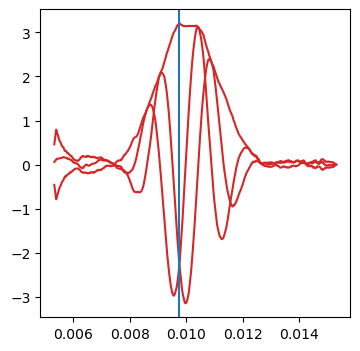

In [269]:
#plt.plot(tlist, chan1_smooth, color = "tab:red")
plt.plot(tlist, chan1_smooth, color = "tab:red")
plt.plot(tlist, chan2_smooth, color = "tab:red")
plt.plot(tlist, trans_mag, color = "tab:red")
plt.axvline(tlist[np.argmax(trans_mag)])
#plt.plot(tlist, chan2_smooth, color = "tab:blue")

In [270]:
data_dir = rel_path / "data/pi_pulse/"

In [271]:
def get_max(time):
    FIDData = pd.read_csv(data_dir / f"{time}.csv", header = None)
    chan1 = FIDData[1].values
    chan2 = FIDData[2].values
    tlist = FIDData[0].values

    chan1 = np.subtract(chan1, np.mean(chan1[2000:]))
    chan2 = np.subtract(chan2, np.mean(chan2[2000:]))
    
    chan1_smooth = smooth(chan1, 35)
    chan2_smooth = smooth(chan2, 35)
    
    trans_mag = np.sqrt(np.square(chan1_smooth) + np.square(chan2_smooth))

    popt, pcov = curve_fit(gaussian, tlist, trans_mag, p0=[3.2, .001, .01])
    print(popt)

    return popt[0], np.sqrt(pcov[2][2])

def gaussian(x, A, sigma, mu):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

In [272]:
data = [(int(f.stem)*2,get_max(f.stem)[0], get_max(f.stem)[1]) for f in data_dir.iterdir()]
times, heights, errs = zip(*sorted(data))

[3.18744558e+00 1.03322382e-03 1.00642311e-02]
[3.18744558e+00 1.03322382e-03 1.00642311e-02]
[3.01247125e+00 1.04879114e-03 1.00386576e-02]
[3.01247125e+00 1.04879114e-03 1.00386576e-02]
[3.11450955e+00 1.02963097e-03 1.00667507e-02]
[3.11450955e+00 1.02963097e-03 1.00667507e-02]
[3.11779434e+00 1.04173155e-03 1.00505631e-02]
[3.11779434e+00 1.04173155e-03 1.00505631e-02]
[3.23893386e+00 1.04344121e-03 1.00535731e-02]
[3.23893386e+00 1.04344121e-03 1.00535731e-02]
[3.24098879e+00 1.03591231e-03 1.00634300e-02]
[3.24098879e+00 1.03591231e-03 1.00634300e-02]
[3.19817442e+00 1.03972965e-03 1.00501621e-02]
[3.19817442e+00 1.03972965e-03 1.00501621e-02]
[3.26559113e+00 1.03852672e-03 1.00651184e-02]
[3.26559113e+00 1.03852672e-03 1.00651184e-02]
[2.87365585e+00 1.02961198e-03 1.00871713e-02]
[2.87365585e+00 1.02961198e-03 1.00871713e-02]
[3.27665957e+00 1.03889109e-03 1.00559896e-02]
[3.27665957e+00 1.03889109e-03 1.00559896e-02]
[3.01020365e+00 1.02529595e-03 1.00769646e-02]
[3.01020365e+

In [273]:
def gaussian(t, A, sigma, mu):
    return A * np.exp(-(t-mu)**2/(2*sigma**2))

def quad(t, a,b,c):
    return a*(t-b)**2+c

from scipy.optimize import curve_fit
popt, pcov = curve_fit(quad, times, heights, sigma=errs,p0=[3.21, 1/100, 96])

(2.7, 3.4)

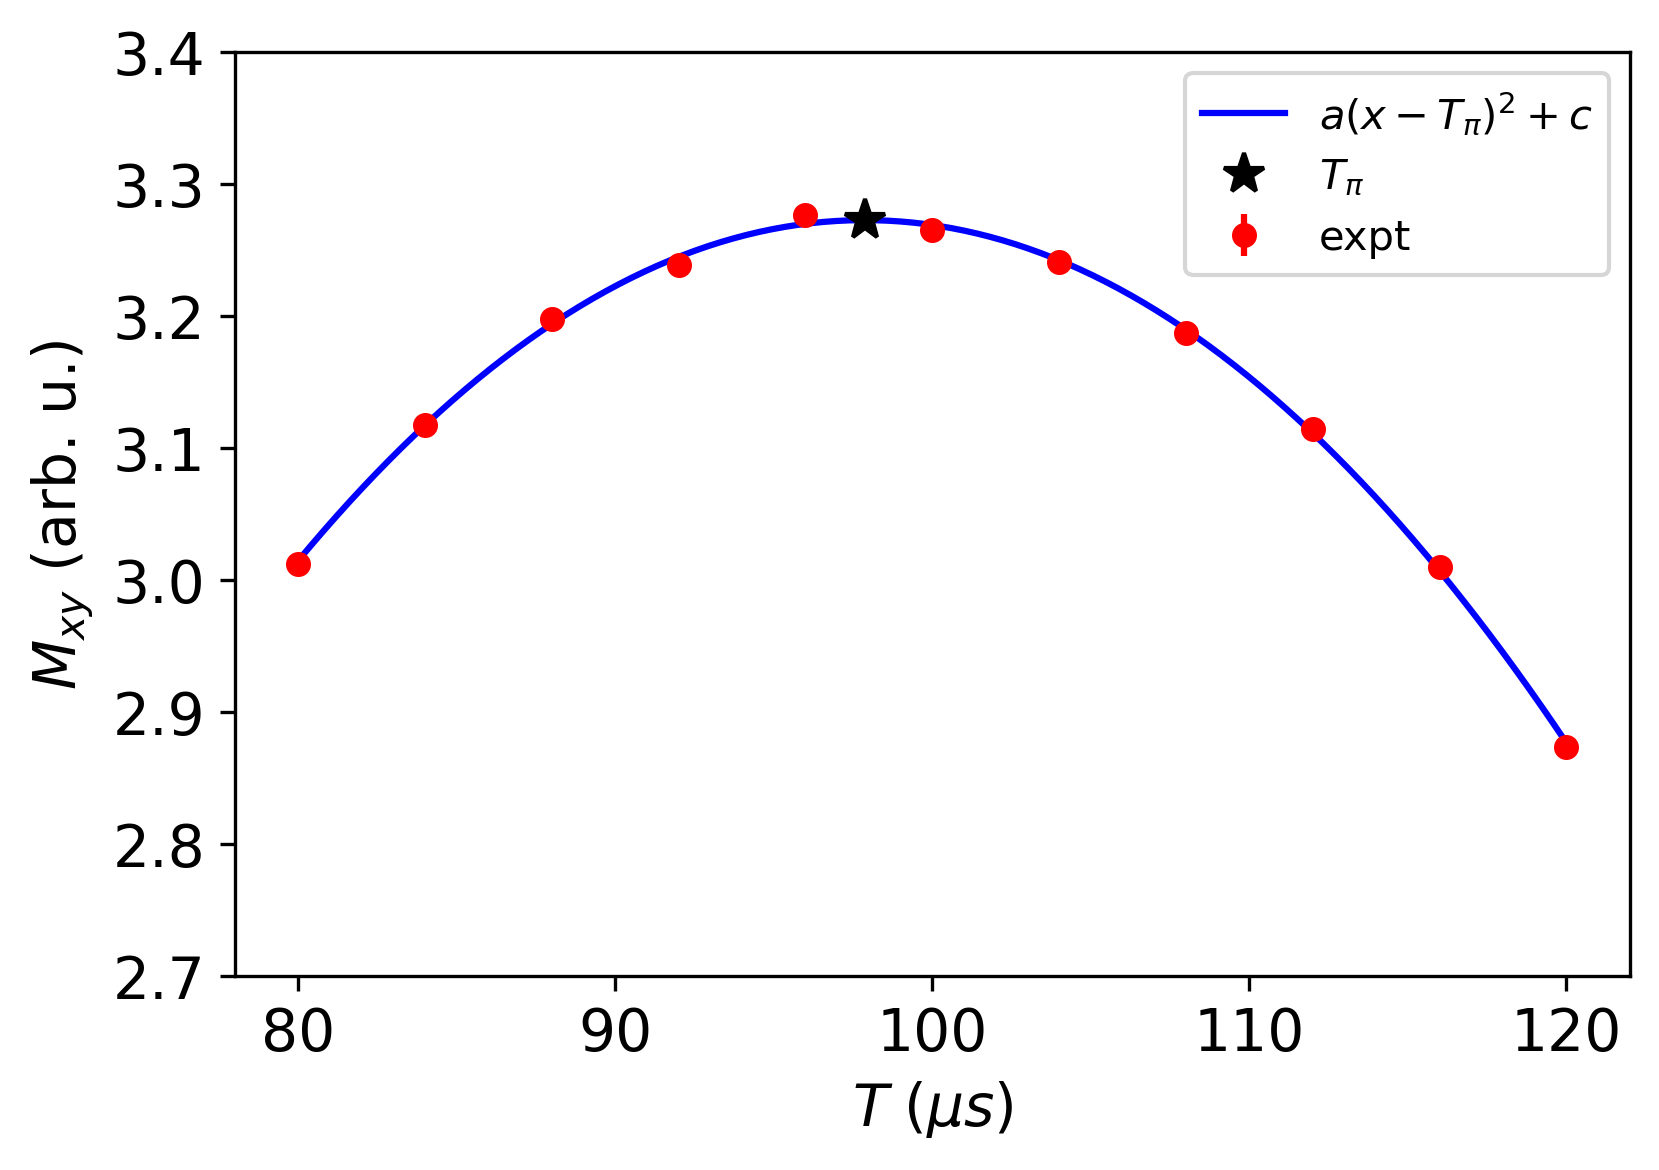

In [274]:
plt.figure(figsize=(6,4),dpi=300)
plt.errorbar(times, heights, yerr = errs,marker = ".",markersize=10, linestyle = "None", color = "r", label = "expt")
xlist = np.linspace(min(times), max(times), 100)
plt.plot(xlist, [quad(x, *popt) for x in xlist], color = "b", label = r"$a(x-T_\pi)^2+c$")
plt.plot(popt[1], max([quad(x, *popt) for x in xlist]), "*k", markersize=10, label = r"$T_{\pi}$",)
plt.legend(loc=1)
plt.tick_params(labelsize=14)
plt.xlabel("$T\; (\mu s)$", fontsize = 14)
plt.ylabel("$M_{xy}$ (arb. u.)", fontsize = 14)
# plt.gcf().set_dpi(200)
plt.ylim([2.7, 3.4])

In [275]:
plt.close()
popt

array([-8.08221770e-04,  9.78664959e+01,  3.27275904e+00])

In [276]:
popt[1]

97.8664958795398

In [277]:
np.pi/(popt[1]*1e-3)

32.10079839229824

In [278]:
pcov

array([[ 1.31488773e-10, -3.19412483e-07, -1.46832537e-08],
       [-3.19412483e-07,  7.50588081e-03,  1.74566328e-05],
       [-1.46832537e-08,  1.74566328e-05,  3.71892853e-06]])

In [279]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(gaussian, tlist, trans_mag, p0=[3.2, .001, .01])

(4.0, 18.0)

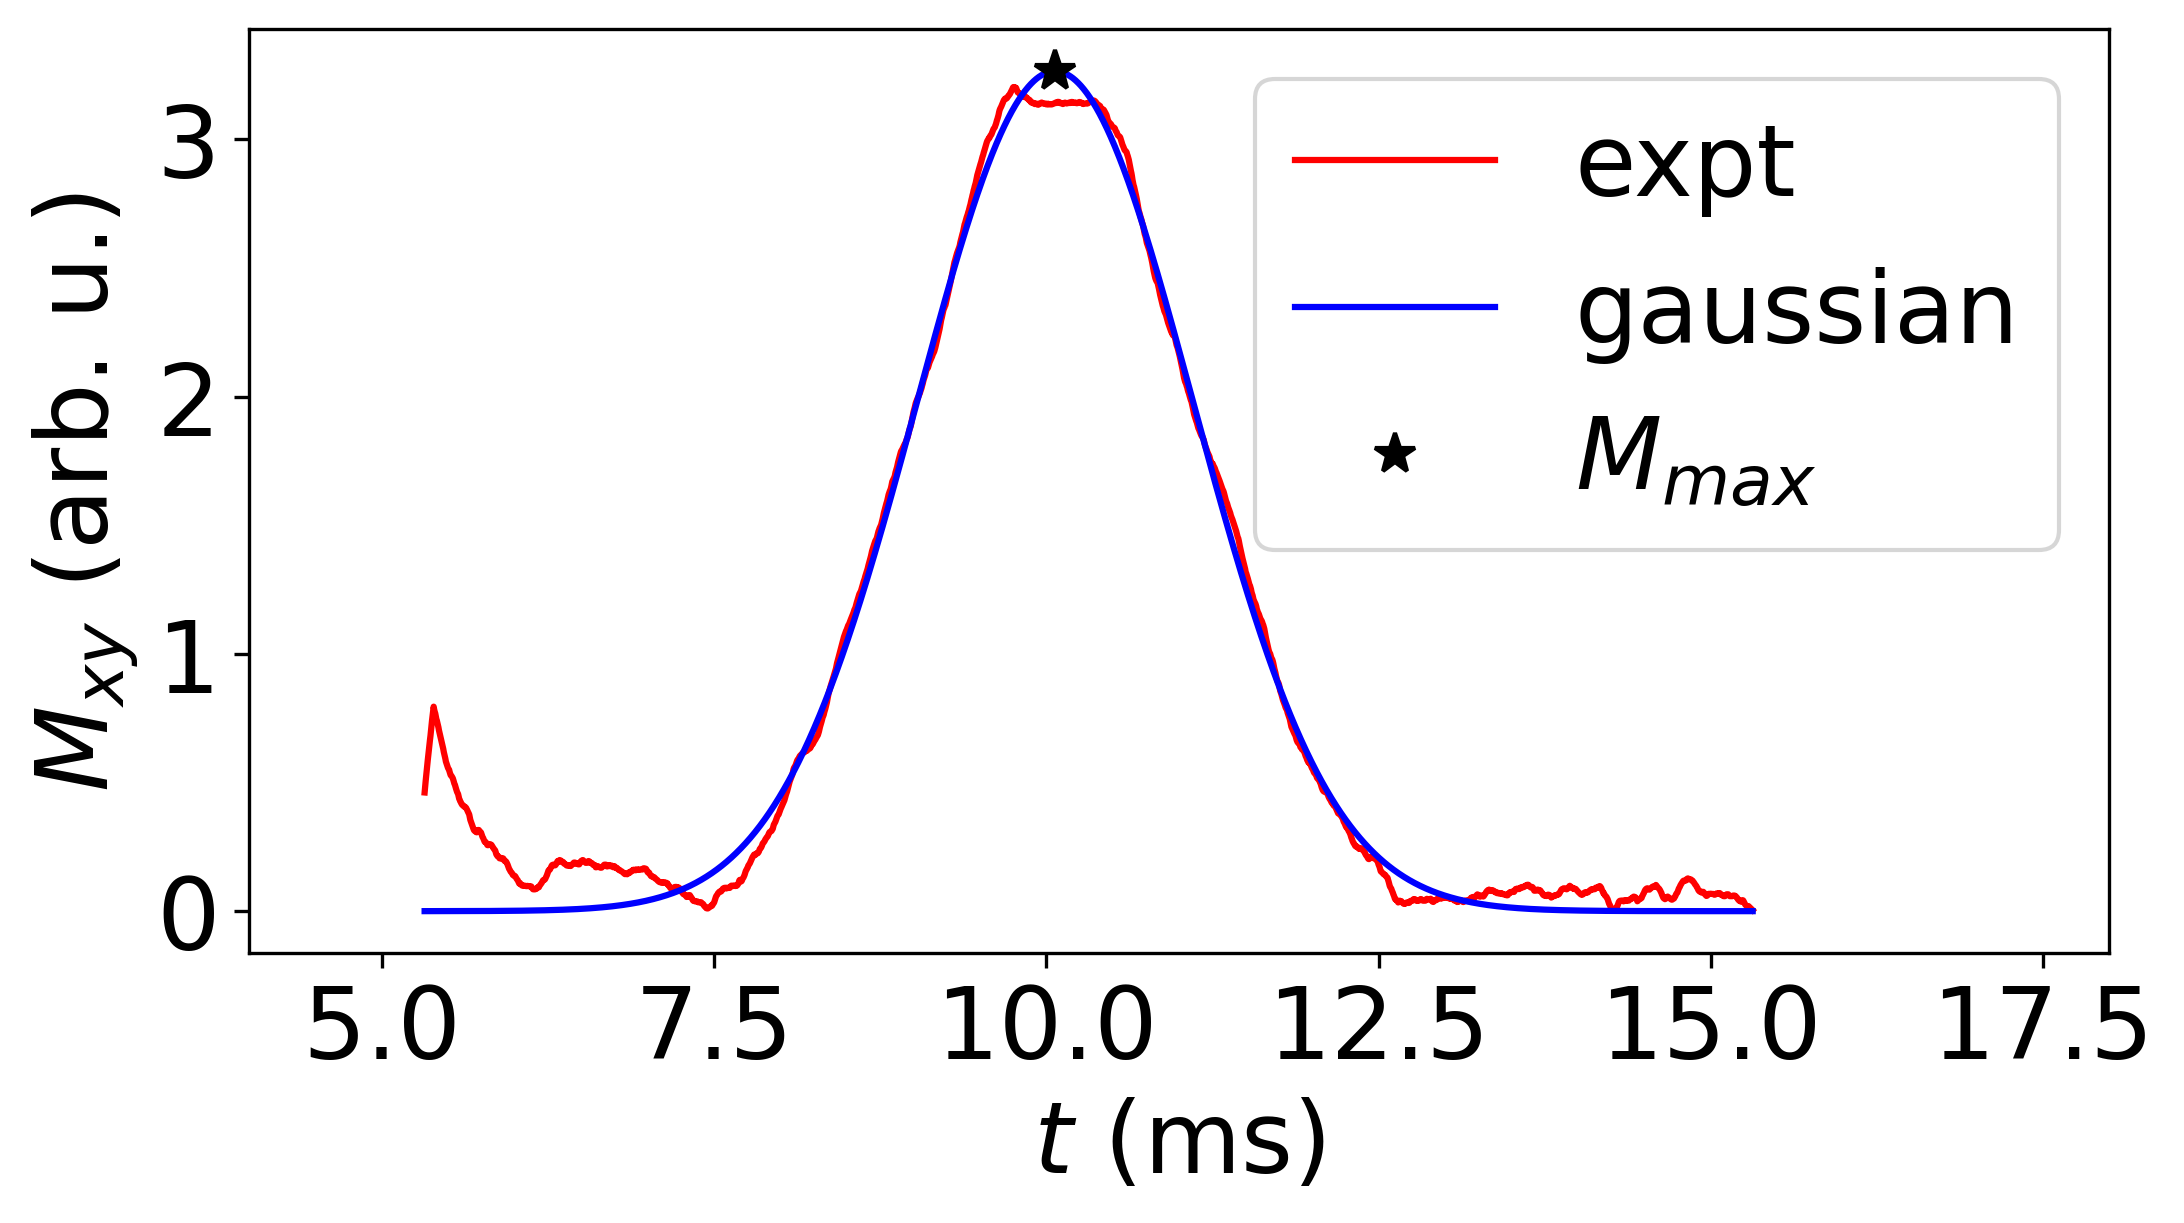

In [280]:
plt.figure(figsize=(8,4),dpi=300)
plt.plot(tlist*1e3, trans_mag, c="r", label = "expt")
plt.plot(tlist*1e3, gaussian(np.array(tlist), *popt), c="b", label = "gaussian")
plt.plot(tlist[np.argmax(gaussian(np.array(tlist), *popt))]*1e3, popt[0], '*k', markersize=10, label="$M_{max}$")
plt.legend(fontsize = 24)
plt.ylabel("$M_{xy}$ (arb. u.)", fontsize = 24)
plt.xlabel("$t$ (ms)", fontsize = 24)
plt.tick_params(labelsize=24)
# plt.gcf().set_size_inches(7,3)
plt.xlim([4, 18])
# plt.gcf().set_dpi(200)

In [15]:
pcov

array([[ 6.12832851e-05, -1.29929465e-08,  2.00176431e-15],
       [-1.29929465e-08,  8.26407993e-12, -6.81625462e-19],
       [ 2.00176431e-15, -6.81625462e-19,  8.26407948e-12]])